Neuroon evaluation using metric functions
-----------------------------------------

Here we will compare neuroon staging against psg staging assumed to be ground truth. Confusion matrixes will be created for classification performance for each stage. They represent the percentage overlap between neuroon and psg staging.

Coonfusion matrix scheme :


| Neuroon / PSG 	| Yes            	| No             	|
|---------------	|----------------	|----------------	|
| Yes           	| True Positive  	| True Negative  	|
| No            	| False Positive 	| False Negative 	|



Permutation test on accuracy score will be used to assess whether observed confusion matrix could have been produced by chance.

Accuracy is defined as:

$$\frac{\sum{TruePositive} + \sum{TrueNegative}} {\sum{TotalPopulation}}$$

i.e. accuracy is a summary statistic of confusion matrix: sum of matrix diagonal divided by its total sum

Cohen cappa [2] will be used to determine if the simmilarity between neuroon and psg was obtained by chance or randomly. 



Cohen cappa is the percent agreement between two raters corrected for possibility of agreement by chance.
Cohen cappa is defined as [1]:


$$\kappa = \frac{P(a) - P(e)}{1-P(e)}$$

* P(a) is the observed agreement
* P(e) is the chance agreement

$$ P(e) = \frac{\frac{cm^1 * rm^1}{n} + \frac{cm^2 * rm^2}{n}}{n} $$

where:
* cm1 represents column 1 marginal
* cm2 represents column 2 marginal
* rm1 represents row 1 marginal
* rm2 represents row 2 marginal

n represents the total number of observations

<img src="images/cohen_tresholds.png" ,width=400, height=400> 


[1] Mchugh, M. L. (2012). Interrater reliability : the kappa statistic. Biochemia Medica., 22(3), 276–282.

[2] Cohen, J. (1960). A coefficient of agreement for nominal scales. Educational and Psychosocial Measurement, 20, 37-46.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict 
import parse_hipnogram as ph
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
import sklearn.metrics as metrics
from matplotlib.dates import  DateFormatter
import seaborn as sns
from datetime import timedelta
plt.rcParams['figure.figsize'] = (9.0, 5.0)
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')

from statsmodels.stats.inter_rater import cohens_kappa, to_table
labels = ['rem','N1', 'N2', 'N3','wake']

stage_to_num = {'W':5, 'R':1, 'N1':2 , 'N2':3, 'N3':4 }
dummy_dict = {'stage_1': 'rem', 'stage_2' : 'N1', 'stage_3' : 'N2', 'stage_4': 'N3', 'stage_5':'wake'}
stage_color_dict = {'N1' : 'royalblue', 'N2' :'forestgreen', 'N3' : 'coral', 'rem' : 'plum', 'wake' : 'lightgray' }



loading


/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
# load hipnograms, resample them and select their common time window

psg_hipnogram = ph.parse_psg_stages().resample('1s').fillna(method = 'ffill')
neuroon_hipnogram = ph.parse_neuroon_stages().resample('1s').fillna(method = 'ffill')

# Get the start and end of the time window covered by both hipnograms
start = neuroon_hipnogram.index.searchsorted(psg_hipnogram.index.get_values()[0])
end = psg_hipnogram.index.searchsorted(neuroon_hipnogram.index.get_values()[-1])

# Trim hipnograms to the common time window so the confusion matrix calculations are accurate
# +1 and -1 because events got cut in half, resulting in ends without starts
neuroon_hipnogram = neuroon_hipnogram.ix[start ::]
# +1 because upper bound is not included
psg_hipnogram = psg_hipnogram.ix[0:end +1]

parse_hipnogram.py:133: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  psg_stages = psg_stages.append(psg_copy).sort('order')
/Users/ryszardcetnarski/.virtualenvs/notebook/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
parse_hipnogram.py:68: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  neuroon_stages = neuroon_stages.sort(columns = 'timestamp')


In [5]:
# Create a list of staging predictions
true_stage = psg_hipnogram['stage_num'].as_matrix()
predicted_stage = neuroon_hipnogram['stage_num'].astype(int).as_matrix()

# Compute precision, recall and f1-score for the multilabel classification from neuroon
report = metrics.classification_report(true_stage,predicted_stage, target_names = labels )
# Compute accuracy, give it this name to use after permutation
original_accuracy = metrics.accuracy_score(true_stage,predicted_stage,)

print(report)
print('accuracy: %.2f'%original_accuracy)


             precision    recall  f1-score   support

        rem       0.57      0.58      0.58      4710
         N1       0.00      0.00      0.00      2760
         N2       0.46      0.79      0.58     10110
         N3       0.47      0.41      0.44      6690
       wake       0.57      0.03      0.05      3643

avg / total       0.45      0.48      0.42     27913

accuracy: 0.48


/Users/ryszardcetnarski/.virtualenvs/notebook/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [6]:
def binarize_stages(hipnogram):
    return pd.get_dummies(hipnogram, prefix = 'stage')

In [9]:

def confusion_matrix_separate():
    # make a confusion matrix for each stage binarized (stage = 1, all_other = 0)
    # TODO, neuroon stages saved as float, change to int upstream
    neuroon_binarized = binarize_stages(neuroon_hipnogram['stage_num'].astype(int))
    psg_binarized = binarize_stages(psg_hipnogram['stage_num'])
    
    fig, axes = plt.subplots(nrows = 2,ncols = 2, figsize = (8,8))
    
    roc_fig, roc_axes = plt.subplots(figsize = (6,6))
    roc_fig.suptitle('ROC')
    
    for neuroon_stage, ax in zip(neuroon_binarized, axes.reshape(-1)):
        
        stage_predicted = neuroon_binarized[neuroon_stage].as_matrix()
        stage_true = psg_binarized[neuroon_stage].as_matrix()

        # Compute the confusion matrix [[tp, fn], [fp, tn]]
        cm = confusion_matrix(stage_true, stage_predicted)
        
        
        # Confusion matrix is organized accroding to dummy coding, so the upper right cell [0,0] will have true negatives (psg = 0 and neuroon = 0)
        # This is not accroding to the conventional way of viualizing the matrix, so we'll rotate it
        cm = np.rot90(cm, 2)
        
        # Compute the cohen cappa for the confusion matrix
        table = cohens_kappa(cm)

        # Normalize the confusion matrix by row (i.e by the number of samplesin each class)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #cm_normalized = cm
        # Make a plot of scores in the roc space, i.e. fp vs tp
        roc_axes.plot(cm_normalized[1,0], cm_normalized[0,0], marker= 'o', color = stage_color_dict[dummy_dict[neuroon_stage]], label = dummy_dict[neuroon_stage])
        
        #Plot the whole confusion matrix normalized to show percentages
        sns.heatmap(cm_normalized, annot = True, xticklabels = ['yes','no'],  yticklabels = ['yes','no'],fmt = '.2f', ax = ax)
        
        ax.set_title(dummy_dict[neuroon_stage] + '\n Cohen cappa: %.2f'%table.kappa)
        ax.set_ylabel('psg')
        ax.set_xlabel('neuroon')
        fig.tight_layout()
        
        print(dummy_dict[neuroon_stage])
        # uncomment to see other results, confidence intervals 
        print('max kappa %.2f'%table.kappa_max)
        print(table)
        
    roc_axes.plot([0,1], [0,1], color = 'black', linestyle = '--', alpha = 0.5)
    roc_axes.set_xlabel('false_positive')
    roc_axes.set_ylabel('true_positive')
    roc_axes.legend(loc = 'upper left')

rem
max kappa 0.99
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.4902
              ASE                       0.0069
              95% Lower Conf Limit      0.4766
              95% Upper Conf Limit      0.5038

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0060
              Z                         81.9062
              One-sided Pr >  Z         0.0000
              Two-sided Pr > |Z|        0.0000

N2
max kappa 0.52
                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.2331
              ASE                       0.0050
              95% Lower Conf Limit      0.2233
              95% Upper Conf Limit      0.2429

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0053
              Z                         44.2625
              One-sided Pr

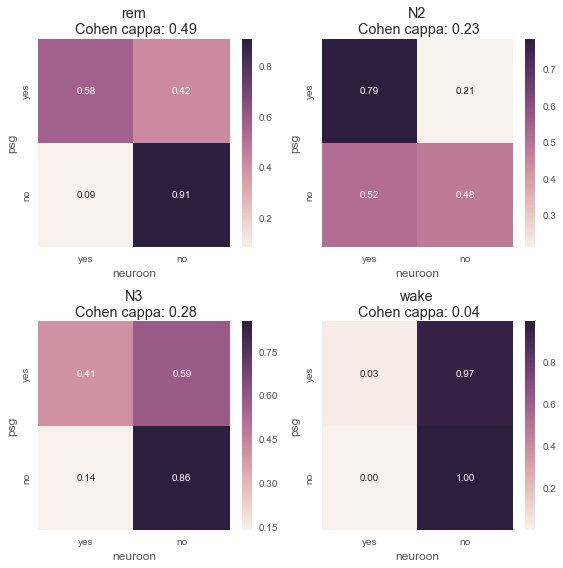

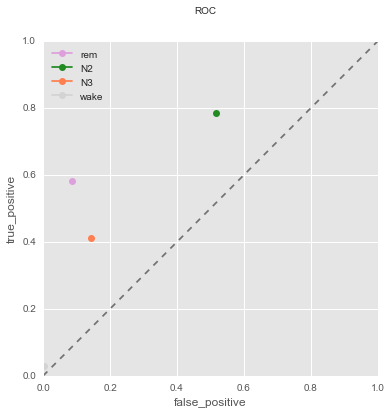

In [10]:
confusion_matrix_separate()

In [21]:
# Run permutation test by shuffling (without replacement) the stage labels neuroon assigned in original 30sec freq staging
def permute_neuroon_staging():
    # load hipnograms, resample them and select their common time window
    neuroon_hipnogram = ph.parse_neuroon_stages(permute = True).resample('1s').fillna(method = 'ffill')
    psg_hipnogram = ph.parse_psg_stages().resample('1s').fillna(method = 'ffill')

    # Get the start and end of the time window covered by both hipnograms
    start = neuroon_hipnogram.index.searchsorted(psg_hipnogram.index.get_values()[0])
    end = psg_hipnogram.index.searchsorted(neuroon_hipnogram.index.get_values()[-1])

    # Trim hipnograms to the common time window so the confusion matrix calculations are accurate
    # +1 and -1 because events got cut in half, resulting in ends without starts
    neuroon_hipnogram = neuroon_hipnogram.ix[start ::]
    # +1 because upper bound is not included
    psg_hipnogram = psg_hipnogram.ix[0:end +1]
    
    true_stage = psg_hipnogram['stage_num'].as_matrix()
    predicted_stage = neuroon_hipnogram['stage_num'].astype(int).as_matrix()
    
    # Measure accuracy score 
    acc_score = metrics.accuracy_score(true_stage,predicted_stage)
    
    return acc_score



In [19]:
num_perm = 100
permuted_accuracy = []
for i in range(num_perm):
    permuted_accuracy.append(permute_neuroon_staging())

permuted_accuracy = np.array(permuted_accuracy)

roc_axes.plot([0,1], [0,1], color = 'black', linestyle = '--', alpha = 0.5)
roc_axes.set_xlabel('false_positive')
roc_axes.set_ylabel('true_positive')
roc_axes.legend(loc = 'upper left')

/Users/ryszardcetnarski/.virtualenvs/notebook/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


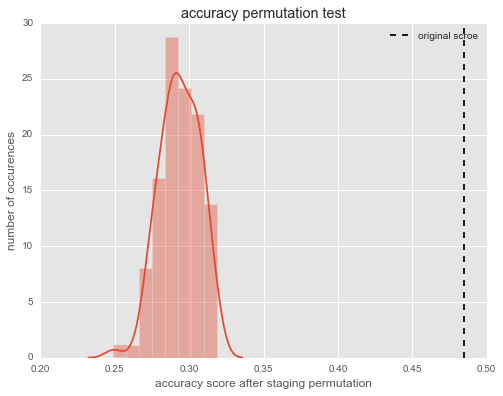

In [20]:
fig, axes = plt.subplots(figsize = (8,6))
axes.axvline(original_accuracy, color = 'k', linestyle = '--', label = 'original scroe')
sns.distplot(permuted_accuracy, ax = axes)

axes.set_title('accuracy permutation test')
axes.set_ylabel('number of occurences')
axes.set_xlabel('accuracy score after staging permutation')
axes.legend()